In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./backend')
import numpy as np
import pandas as pd

import sglm
import sglm_cv
import sglm_pp
import sglm_test

In [3]:
df = pd.read_csv('../C39v2_sampleDesignMat.csv').drop('Unnamed: 0', axis=1).drop('index', axis=1)

In [4]:
with pd.option_context('max_columns',100):
    display(df)

,nTrial,iBlock,iTrial,iOccurrence,iState_start,iState_end,analog1,analog2,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,bl0,bl1,bl2,bl3,bl4,bl5,bl6,r-5,r-4,r-3,r-2,r-1,r0,r1,r2,r3,r4,r5,grnL
0,4.0,1.0,0.0,0.0,23.0,29.0,1123.0,2744.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,921.93774
1,4.0,1.0,0.0,1.0,29.0,30.0,229.0,5.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,950.58765
2,4.0,1.0,0.0,2.0,30.0,30.0,229.0,6.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,944.09120
3,4.0,1.0,0.0,3.0,30.0,30.0,1123.0,2753.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,948.26196
4,4.0,1.0,0.0,4.0,30.0,30.0,1122.0,2746.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,945.38464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,239.0,13.0,0.0,1128.0,21.0,14.0,229.0,5.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.06330
234924,239.0,13.0,0.0,1129.0,14.0,24.0,231.0,7.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.59150
234925,239.0,13.0,0.0,1130.0,24.0,25.0,1123.0,2748.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.45250
234926,239.0,13.0,0.0,1131.0,25.0,27.0,1122.0,2746.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,855.09950


In [5]:
df['decision'].unique()

array(['False', '1.0', '-1.0'], dtype=object)

In [46]:
key_cols = [
    'nTrial', # trial ID
    'iBlock', # block number within session
    'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1)
    'ENLPenalty', # lick during ENL period (no directionality yet, 0,1)
    'Select', # binary selection lick
    'Consumption', # consumption period (from task perspective)
    'TO', # timeout trial
    'responseTime', # task state cue to selection window
    'ENL', # task state ENL window
    'Cue', # task state Cue window
    'decision', # choice lick direction (aligned to select but with directionality -1,1)
    'switch', # switch from previous choice on selection (-1,1)
    'selR', # select reward (-1,1) aligned to selection
    'selHigh', # select higher probability port (-1,1)
    'Reward', # reward vs no reward during consumption period (-1,1)
    'post', # log-odds probability
    'grnL', # photometry response
]

# key_cols += [f'bl{n}' for n in range(7)] # block position
# key_cols += [f'r{n}' for n in range(-5,6)] # reward or no reward sequence

dfkc = df[key_cols].copy()
# dfkc = dfkc.replace('False', False)
dfkc = dfkc.replace('False', np.nan).astype(float)
dfkc = dfkc*1

dfkc = dfkc.dropna(thresh=12)

with pd.option_context('max_columns',100):
    display(dfkc)

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,grnL
327,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,NaN,NaN,998.04170
328,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,995.86380
329,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,993.48110
330,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,990.83026
331,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,987.99720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234912,239.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.56450
234913,239.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.63965
234914,239.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.94640
234915,239.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,851.14150


In [74]:
# predictors = key_cols[4:7]
predictors = key_cols[4:]
prd = dfkc[predictors]
prd

resp = dfkc['grnL']

In [75]:
prd_ex = prd.iloc[0:5].copy()
prd_ex

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,grnL
327,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,NaN,NaN,998.04170
328,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,995.86380
329,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,993.48110
330,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,990.83026
331,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,987.99720


In [76]:
shift_amt_list = [0, -1, 1]
pandas_shifted = sglm_pp.timeshift_multiple(prd_ex, shift_amt_list=shift_amt_list)
numpy_shifted = sglm_pp.timeshift_multiple(prd_ex.values, shift_amt_list=shift_amt_list)

display(pandas_shifted)
display(numpy_shifted)

# glm = sglm.GLM('Normal')


,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,responseTime_1,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1
327,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
328,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,NaN,NaN,998.04170
329,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,995.86380
330,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,993.48110
331,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,990.83026


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,             nan,             nan,
         9.98041700e+02,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,             nan,             nan,
                    nan,             nan,  1.00000000e+00,
         9.87058026e-01,  9.95863800e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                    nan,             nan,             nan,
                    nan,  1.00000000e+00,  9.87058026e-

In [77]:
pandas_shifted['Consumption_diff'] = sglm_pp.diff(pandas_shifted['Consumption'])
pandas_shifted

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
327,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0
328,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,-1.0,1.0,1.0,NaN,NaN,998.04170,1.0
329,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,995.86380,0.0
330,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,993.48110,0.0
331,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,990.83026,0.0


In [78]:
prd_sft = sglm_pp.timeshift_multiple(prd, shift_amt_list=shift_amt_list)
prd_sft['Consumption_diff'] = sglm_pp.diff(prd_sft['Consumption'])
prd_sft['grnL'] = resp
prd_sft

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
327,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0
328,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,-1.0,1.0,1.0,NaN,NaN,998.04170,1.0
329,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,995.86380,0.0
330,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,993.48110,0.0
331,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.987058,990.83026,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234912,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.41350,0.0
234913,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.56450,0.0
234914,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.63965,0.0
234915,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.958604,850.94640,0.0


In [79]:
prd_sft = prd_sft.fillna(0)

In [80]:
prd_sft.dtypes

Select              float64
Consumption         float64
TO                  float64
responseTime        float64
ENL                 float64
Cue                 float64
decision            float64
switch              float64
selR                float64
selHigh             float64
Reward              float64
post                float64
grnL                float64
Select_-1           float64
Consumption_-1      float64
TO_-1               float64
responseTime_-1     float64
ENL_-1              float64
Cue_-1              float64
decision_-1         float64
switch_-1           float64
selR_-1             float64
selHigh_-1          float64
Reward_-1           float64
post_-1             float64
grnL_-1             float64
Select_1            float64
Consumption_1       float64
TO_1                float64
responseTime_1      float64
ENL_1               float64
Cue_1               float64
decision_1          float64
switch_1            float64
selR_1              float64
selHigh_1           

In [87]:
glm = sglm.GLM('Normal')
glm.fit(prd_sft[[_ for _ in prd_sft.columns if 'grnL' not in _]].fillna(0).values, resp.values)

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


In [89]:
glm.model.predict(prd_sft[[_ for _ in prd_sft.columns if 'grnL' not in _]].fillna(0).values)

array([872.28616158, 891.32269326, 910.07264541, ..., 867.65146023,
       867.65146023, 861.59792559])

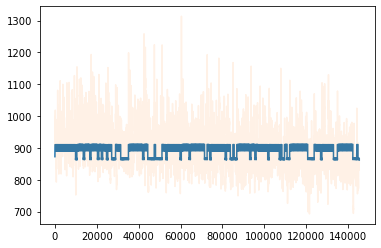

In [91]:
import matplotlib.pyplot as plt
plt.plot(glm.model.predict(prd_sft[[_ for _ in prd_sft.columns if 'grnL' not in _]].fillna(0).values))
plt.plot(prd_sft['grnL'].values, alpha = 0.1)